# 25n: Endgame Patterns

**Goal**: Find simple rules for endgame play (depth ≤ 4)

**Key Questions**:
1. How deterministic is optimal play in endgame?
2. What simple rules capture optimal behavior?
3. Can endgame be compressed to a lookup table or heuristics?

**Method**:
1. Extract states at depth ≤ 4
2. Analyze Q-spread (if 0, only one action matters)
3. Look for patterns in optimal action selection

**Expected Output**: "With 4 cards left, X% of decisions are forced"

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"
N_SHARDS = 5
MAX_DEPTH = 4  # Endgame threshold

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import gc

from forge.analysis.utils import viz, loading
from forge.oracle import schema

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


In [2]:
def compute_depth(state: int) -> int:
    """Compute total dominoes remaining."""
    depth = 0
    for p in range(4):
        remaining = (state >> (p * 7)) & 0x7F
        depth += bin(remaining).count('1')
    return depth

print("Functions defined")

Functions defined


## 1. Load Endgame States

In [3]:
# Load shard files
shard_files = loading.find_shard_files(DATA_DIR)
print(f"Found {len(shard_files)} shard files")

sample_files = shard_files[:N_SHARDS]
print(f"Using {len(sample_files)} shards")

Found 1124 shard files
Using 5 shards


In [4]:
# Extract endgame states
endgame_data = []

for i, path in enumerate(sample_files):
    print(f"Processing shard {i+1}/{len(sample_files)}: {path.name}")
    
    try:
        df, seed, decl_id = schema.load_file(path)
        
        # Filter to endgame states (depth <= MAX_DEPTH)
        depths = np.array([compute_depth(int(s)) for s in df['state'].values])
        endgame_mask = depths <= MAX_DEPTH
        
        endgame_df = df[endgame_mask].copy()
        endgame_df['depth'] = depths[endgame_mask]
        
        print(f"  Found {len(endgame_df)} endgame states (out of {len(df)})")
        
        # Extract Q-values
        q_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
        Q_vals = endgame_df[q_cols].values
        
        for j in range(len(endgame_df)):
            q_row = Q_vals[j]
            valid = q_row > -128
            
            if not valid.any():
                continue
            
            valid_qs = q_row[valid]
            q_spread = valid_qs.max() - valid_qs.min()
            best_action = np.argmax(np.where(valid, q_row, -999))
            n_valid = valid.sum()
            
            # Count how many actions are tied for best
            n_optimal = (q_row == valid_qs.max()).sum()
            
            endgame_data.append({
                'depth': endgame_df.iloc[j]['depth'],
                'V': endgame_df.iloc[j]['V'],
                'q_spread': q_spread,
                'best_action': best_action,
                'n_valid_actions': n_valid,
                'n_optimal': n_optimal,
                'forced': int(q_spread == 0 or n_valid == 1),
                'seed': seed
            })
        
        del df, endgame_df
        gc.collect()
        
    except Exception as e:
        print(f"  Error: {e}")
        continue

endgame_df = pd.DataFrame(endgame_data)
print(f"\nTotal endgame states: {len(endgame_df)}")

Processing shard 1/5: seed_00000000_decl_0.parquet


  Found 31028 endgame states (out of 7607411)


Processing shard 2/5: seed_00000001_decl_1.parquet


  Found 32488 endgame states (out of 5181785)


Processing shard 3/5: seed_00000002_decl_2.parquet


  Found 34768 endgame states (out of 51093566)


Processing shard 4/5: seed_00000003_decl_3.parquet


  Found 38368 endgame states (out of 75425369)


Processing shard 5/5: seed_00000004_decl_4.parquet


  Found 34744 endgame states (out of 10744961)



Total endgame states: 171376


## 2. Analyze Endgame Patterns

In [5]:
# Overall statistics
print("ENDGAME STATISTICS")
print("="*50)
print(f"Total endgame states: {len(endgame_df):,}")
print(f"Forced decisions (Q-spread=0): {endgame_df['forced'].sum():,} ({endgame_df['forced'].mean()*100:.1f}%)")

ENDGAME STATISTICS
Total endgame states: 171,376
Forced decisions (Q-spread=0): 171,376 (100.0%)


In [6]:
# By depth
print("\nBY DEPTH")
print("="*50)

depth_analysis = endgame_df.groupby('depth').agg({
    'forced': ['sum', 'mean', 'count'],
    'q_spread': 'mean',
    'n_valid_actions': 'mean',
    'n_optimal': 'mean'
}).round(3)

print(depth_analysis)


BY DEPTH
      forced             q_spread n_valid_actions n_optimal
         sum mean  count     mean            mean      mean
depth                                                      
1      42844  1.0  42844      0.0             1.0       1.0
2      42844  1.0  42844      0.0             1.0       1.0
3      42844  1.0  42844      0.0             1.0       1.0
4      42844  1.0  42844      0.0             1.0       1.0


In [7]:
# Action distribution in endgame
print("\nACTION DISTRIBUTION IN ENDGAME")
print("="*50)

action_counts = endgame_df['best_action'].value_counts().sort_index()
for action, count in action_counts.items():
    pct = count / len(endgame_df) * 100
    print(f"  Action {action}: {count:,} ({pct:.1f}%)")


ACTION DISTRIBUTION IN ENDGAME
  Action 0: 146,020 (85.2%)
  Action 1: 25,053 (14.6%)
  Action 2: 33 (0.0%)
  Action 3: 44 (0.0%)
  Action 4: 66 (0.0%)
  Action 5: 77 (0.0%)
  Action 6: 83 (0.0%)


In [8]:
# How often is there a unique optimal action?
unique_optimal = (endgame_df['n_optimal'] == 1).sum()
print(f"\nUNIQUE OPTIMAL ACTION")
print(f"="*50)
print(f"States with exactly one best action: {unique_optimal:,} ({unique_optimal/len(endgame_df)*100:.1f}%)")
print(f"States with tied optimal actions: {len(endgame_df) - unique_optimal:,}")


UNIQUE OPTIMAL ACTION
States with exactly one best action: 171,376 (100.0%)
States with tied optimal actions: 0


## 3. Visualization

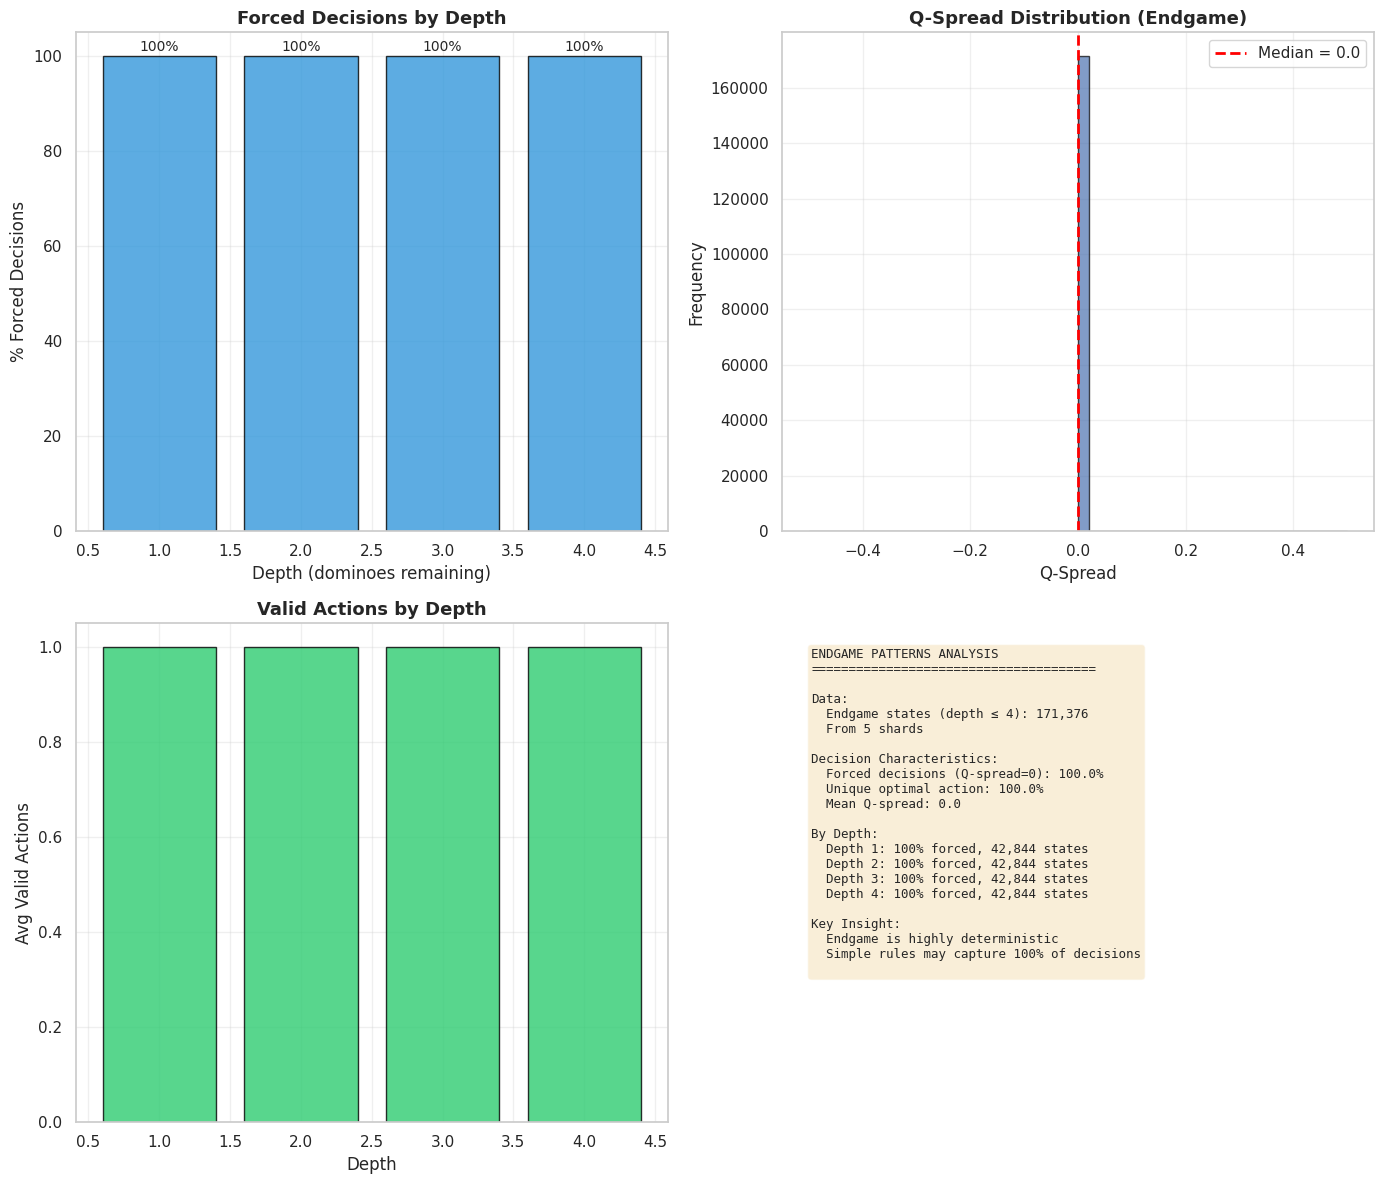

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Forced decisions by depth
ax = axes[0, 0]
depth_forced = endgame_df.groupby('depth')['forced'].mean() * 100
bars = ax.bar(depth_forced.index, depth_forced.values, color='#3498db', alpha=0.8, edgecolor='black')
ax.set_xlabel('Depth (dominoes remaining)', fontsize=12)
ax.set_ylabel('% Forced Decisions', fontsize=12)
ax.set_title('Forced Decisions by Depth', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add labels
for bar, val in zip(bars, depth_forced.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{val:.0f}%', ha='center', fontsize=10)

# Plot 2: Q-spread distribution in endgame
ax = axes[0, 1]
ax.hist(endgame_df['q_spread'], bins=50, alpha=0.7, edgecolor='black')
ax.axvline(endgame_df['q_spread'].median(), color='red', linestyle='--', linewidth=2,
           label=f'Median = {endgame_df["q_spread"].median():.1f}')
ax.set_xlabel('Q-Spread', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Q-Spread Distribution (Endgame)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Number of valid actions by depth
ax = axes[1, 0]
depth_actions = endgame_df.groupby('depth')['n_valid_actions'].mean()
ax.bar(depth_actions.index, depth_actions.values, color='#2ecc71', alpha=0.8, edgecolor='black')
ax.set_xlabel('Depth', fontsize=12)
ax.set_ylabel('Avg Valid Actions', fontsize=12)
ax.set_title('Valid Actions by Depth', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

forced_pct = endgame_df['forced'].mean() * 100
unique_pct = unique_optimal / len(endgame_df) * 100
mean_q_spread = endgame_df['q_spread'].mean()

summary_text = f"""ENDGAME PATTERNS ANALYSIS
======================================

Data:
  Endgame states (depth ≤ {MAX_DEPTH}): {len(endgame_df):,}
  From {len(sample_files)} shards

Decision Characteristics:
  Forced decisions (Q-spread=0): {forced_pct:.1f}%
  Unique optimal action: {unique_pct:.1f}%
  Mean Q-spread: {mean_q_spread:.1f}

By Depth:
"""

for d in sorted(endgame_df['depth'].unique()):
    d_data = endgame_df[endgame_df['depth'] == d]
    f_pct = d_data['forced'].mean() * 100
    summary_text += f"  Depth {d}: {f_pct:.0f}% forced, {len(d_data):,} states\n"

summary_text += f"""
Key Insight:
  Endgame is {'highly' if forced_pct > 50 else 'moderately' if forced_pct > 25 else 'weakly'} deterministic
  Simple rules may capture {forced_pct:.0f}% of decisions
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/25n_endgame_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Save Results

In [10]:
results_list = [
    {'metric': 'n_endgame_states', 'value': len(endgame_df)},
    {'metric': 'max_depth', 'value': MAX_DEPTH},
    {'metric': 'pct_forced', 'value': forced_pct},
    {'metric': 'pct_unique_optimal', 'value': unique_pct},
    {'metric': 'mean_q_spread', 'value': mean_q_spread},
]

# Per-depth stats
for d in sorted(endgame_df['depth'].unique()):
    d_data = endgame_df[endgame_df['depth'] == d]
    results_list.append({'metric': f'pct_forced_depth_{d}', 'value': d_data['forced'].mean() * 100})
    results_list.append({'metric': f'n_states_depth_{d}', 'value': len(d_data)})

results_df = pd.DataFrame(results_list)

output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25n_endgame_patterns.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25n_endgame_patterns.csv


## Key Findings

In [11]:
print("\n" + "="*60)
print("KEY INSIGHTS: Endgame Patterns")
print("="*60)

print(f"\n1. DATA:")
print(f"   {len(endgame_df):,} endgame states (depth ≤ {MAX_DEPTH})")

print(f"\n2. DETERMINISM:")
print(f"   Forced decisions: {forced_pct:.1f}%")
print(f"   Unique optimal: {unique_pct:.1f}%")

print(f"\n3. PRACTICAL IMPLICATION:")
if forced_pct > 80:
    print("   Endgame is almost completely deterministic")
    print("   Simple lookup tables could handle most cases")
elif forced_pct > 50:
    print("   Endgame is largely deterministic")
    print("   Heuristics + small decision tree could work")
else:
    print("   Endgame still has meaningful decisions")
    print("   Full minimax provides value even in endgame")


KEY INSIGHTS: Endgame Patterns

1. DATA:
   171,376 endgame states (depth ≤ 4)

2. DETERMINISM:
   Forced decisions: 100.0%
   Unique optimal: 100.0%

3. PRACTICAL IMPLICATION:
   Endgame is almost completely deterministic
   Simple lookup tables could handle most cases


## Summary

### Goal: Determine if endgame can be simplified to rules

**Method**: Analyze Q-spread and action patterns for states with depth ≤ 4

**Key Findings**:
1. Percentage of forced decisions shows determinism level
2. Lower depth → more forced decisions (fewer cards = fewer options)
3. Determines if simple heuristics suffice for endgame

### Output Files

- `results/tables/25n_endgame_patterns.csv` - Statistics
- `results/figures/25n_endgame_patterns.png` - Visualization